## Decision Tree Code

In [2]:
#Decision Tree 
import random
import sys
import math
import pandas as pd
import matplotlib.pyplot as plt
from decimal import Decimal
import seaborn as sns

class Node(object):
    def __init__(self, attr , thresh):
        self.thres = thresh
        self.attr = attr
        self.leaf = False
        self.predict = None
        self.right = None
        self.left = None
        
## START OF ENTROPY
# Find The Entropy Of The System
def info_entropy(df, attr_to_outcome):
    neg_df = df[df[attr_to_outcome] == 0]
    pos_df = df[df[attr_to_outcome] == 1]
    p = float(pos_df.shape[0])
    n = float(neg_df.shape[0])
    x = p + n
    q = p/(x)
    if p != 0 and n != 0:
        E = -1*((q)*math.log(q, 3) + (1-q)*math.log(1-q, 3))
    else:
        E = 0
    return E

# Weighted Entropy for a Particular Possible Attribute
def remainder(df, rest , outcome):
    val = float(0)
    for rem in rest:
        if rem.shape[0] == 0:
            val = 0
        else:
            val = float(rem.shape[0]/df.shape[0])*info_entropy(rem, outcome) + val
    return val

#First Divides according to threshold then calculates G(S,A)
def info_gain(df, attribute, predict_attr, threshold):
    if predict_attr != None:
        p1 = df[df[attribute] > threshold]
        p2 = df[df[attribute] <= threshold]
        subsets = [p1,p2]
    # Calculates Information Gain(G(S,A)) = E(S) - I(S,A)
    systemEntropy = info_entropy(df, predict_attr)
    weightedEntopy = remainder(df, subsets, predict_attr)
    infoGain = systemEntropy - weightedEntopy
    return infoGain


def choose_entropy_attr(df, attributes, predict_attr):
    max_gain = Decimal("-inf")
    #The Most Optimal Attribute to Return
    most_optimal_attr = None 
    limit = 0
    for attr in attributes:
        sel_db = df[attr]
        converted_v = list(sel_db)
        val = list(set(converted_v))
        val.sort()
        for i in range(1, len(val)):
            x = val[i]
            y = val[i-1]
            threshold = (x + y)/2
            information_obtained = info_gain(df, attr, predict_attr, threshold)
            flag = False
            if information_obtained > max_gain:
                most_optimal_attr = attr
                flag = False
                max_gain = information_obtained
                limit = threshold
    return most_optimal_attr, limit
## END OF ENTROPY

## START OF MISCLASSIFICATION
def choose_attr_misclassification(df,attributes,predict_attr):
    min_gv = float("inf")
    best_attr = None
    limit = 0
    for attr in attributes:
        converted_v = list(df[attr])
        val = list(set(converted_v))
        val.sort()
        for i in range(1, len(val)):
            x = val[i]
            y = val[i-1]
            threshold = (x + y)/2
            information_obtained = misClassification_Average(df, attr, predict_attr, threshold)
            flag = False
            if information_obtained < min_gv:
                min_gv = information_obtained
                flag = True
                best_attr = attr
                limit = threshold
    if min_gv != 0: 
        return best_attr, limit
    else:
        return best_attr, -1

def misClassification_Average(df, attribute, predict_attr , threshold):
    flagCheck = False
    if df[attribute].shape[0] != 0:
        flagCheck = True
    sub1 = df[df[attribute] <= threshold]
    sub2 = df[df[attribute] > threshold]
    size = float(df.shape[0])
    if size == 0:
        return -1
    misClassGain = (sub1.shape[0]/size)*misClass_Avg(sub1, predict_attr) + (sub2.shape[0]/size)*misClass_Avg(sub2,predict_attr)
    return misClassGain

def misClass_Avg(sub, predict_attr):
    p_df = sub[sub[predict_attr] == 1]
    size = float(sub.shape[0])
    if size == 0:
        return 0
    p = float(p_df.shape[0])
    q = float(p/size)
    return min(q,1-q)
## END OF MISCLASSIFICATION

## START OF GINI
def choose_attr_gini(df,attributes,predict_attr):
    min_gini= float("inf")
    best_attr = None
    limit = 0
    for attr in attributes:
        converted_v = list(df[attr])
        val = list(set(converted_v))
        val.sort()
        for i in range(1, len(val)):
            x = val[i]
            y = val[i-1]
            threshold = (x + y)/2
            gini = giniClassification_Average(df, attr, predict_attr, threshold)
            flag = False
            if gini < min_gini:
                min_gini = gini
                best_attr = attr
                limit = threshold
                flag = True
    if min_gini != 0 and min_gini != float("inf"): 
        return best_attr, limit
    else:
        return best_attr, -1

def giniClassification_Average(df, attribute, predict_attr , threshold):
    sub1 = df[df[attribute] <= threshold]
    sub2 = df[df[attribute] > threshold]
    size = float(df.shape[0])
    weightedAvgGini = (sub1.shape[0]/size)*giniAvg(sub1, predict_attr) + (sub2.shape[0]/size)*giniAvg(sub2,predict_attr)
    return weightedAvgGini

def giniAvg(sub, predict_attr):
    p_df = sub[sub[predict_attr] == 1]
    size = float(sub.shape[0])
    if size == 0:
        return 0
    p = float(p_df.shape[0])
    q = float(p/size)
    return 2*q*(1-q)
## END OF GINI

# Builds the Decision Tree based on training data, and then check on Validation Data and Test Set
def build_tree_entropy(df, cols, predict_attr , level , max_depth):
    p_df = df[df[predict_attr] == 1]
    global count
    count += 1
    n_df = df[df[predict_attr] == 0]
    p, n = p_df.shape[0], n_df.shape[0]
    if p == 0 or n == 0 or level == max_depth:
        leaf = Node(None,None)
        if p > n:
            leaf.predict = 1
        else:
            leaf.predict = 0
        leaf.leaf = True
        return leaf
    else:
        #Choose corr best possible attribute
        optimal_attr, threshold = choose_entropy_attr(df, cols, predict_attr)
        if threshold <= 0:
            return makeLeafAtThresh(p,n)
        tree = Node(optimal_attr, threshold)
        sub_2 = df[df[optimal_attr] > threshold]
        sub_1 = df[df[optimal_attr] <= threshold]
        # Recursively build left and right subtree
        tree.left = build_tree_entropy(sub_1, cols, predict_attr, level + 1 , max_depth)
        tree.right = build_tree_entropy(sub_2, cols, predict_attr , level + 1, max_depth)
        return tree

def build_tree_misClassification(df, cols, predict_attr , level , max_depth):
    p_df = df[df[predict_attr] == 1]
    n_df = df[df[predict_attr] == 0]
    global count
    count += 1
    p, n = p_df.shape[0], n_df.shape[0]    
    if p == 0 or n == 0 or level == max_depth:
        leaf = Node(None,None)
        if p > n:
            leaf.predict = 1
        else:
            leaf.predict = 0
        leaf.leaf = True
        return leaf
    else:
        best_attr, threshold = choose_attr_misclassification(df, cols, predict_attr)
        if threshold <= 0:
            return makeLeafAtThresh(p,n)
#         print(str(best_attr) + " " + str(threshold))
        tree = Node(best_attr, threshold)
        sub_1 = df[df[best_attr] <= threshold]
        sub_2 = df[df[best_attr] > threshold]
        # Recursively build left and right subtree
        tree.left = build_tree_misClassification(sub_1, cols, predict_attr, level + 1 , max_depth)
        tree.right = build_tree_misClassification(sub_2, cols, predict_attr , level + 1, max_depth)
        return tree

    
def build_tree_gini(df, cols, predict_attr , level , max_depth):
    p_df = df[df[predict_attr] == 1]
    global count
    count += 1
    n_df = df[df[predict_attr] == 0]
    p, n = p_df.shape[0], n_df.shape[0]
    if p == 0 or level == max_depth or n == 0:
        leaf = Node(None,None)
        if p > n:
            leaf.predict = 1
        else:
            leaf.predict = 0
        leaf.leaf = True
        return leaf
    else:
        #Choose the best attr and the corr. threshold
        best_attr, threshold = choose_attr_gini(df, cols, predict_attr)
        if threshold <= 0:
            return makeLeafAtThresh(p,n)
        tree = Node(best_attr, threshold)
        sub_1 = df[df[best_attr] <= threshold]
        sub_2 = df[df[best_attr] > threshold]
        # Recursively build left and right subtree
        tree.left = build_tree_gini(sub_1, cols, predict_attr, level + 1 , max_depth)
        tree.right = build_tree_gini(sub_2, cols, predict_attr , level + 1, max_depth)
        return tree

def makeLeafAtThresh(p,n):
    leaf = Node(None,None)
    if p > n:
        leaf.predict = 1
    else:
        leaf.predict = 0
    leaf.leaf = True
    return leaf

def predict(node, row_df):
    # Return Predicted Value if Node.Leaf == True
    if node.leaf == False:
        #Choose Left 
        if row_df[node.attr] > node.thres:
            return predict(node.right, row_df)
        #Choose Right
        else:
            return predict(node.left, row_df)
    else:
        return node.predict
    
def printInfo(tp,tn,fp,fn,num_correct,num_data,precision,recall):
    print("The Accuracy :" + str((num_correct/num_data)))
    print("The Precision :" + str(precision))
    print("The Recall :" + str(recall))
    print("The F1 Score :" + str((2*precision*recall)/(precision + recall)))
    print("True Positive is:" + str(tp))
    print("False Negative is:" + str(fn))
    print("True Negative is:" + str(tn))
    print("False Positive is:" + str(fp))
    return round(num_correct/num_data, 3)

# Given a set of data, make a prediction for each instance using the Decision Tree
def test_predictions(root,df):
    total_correct = 0
    size = df.shape[0]
    fn = float(0.0001)
    tp = float(0.0001)
    fp = 0.0001
    tn = 0.0001
    for i,r in df.iterrows():
        prediction = predict(root,r)
        if prediction == r['Outcome']:
            total_correct += 1
        if prediction ==1:
            if r['Outcome'] == 0:
                fp = fp + 1
            else:
                tp = tp + 1
        elif prediction == 0:
            if r['Outcome'] == 1:
                fn = fn + 1
            elif r['Outcome'] == 0:
                tn = tn + 1
    recall = tp/(tp + fn)    
    precision = tp/(tp + fp)
    return printInfo(tp,tn,fp,fn,total_correct,size,precision,recall)
   
def plotGraphFeaturesPrimary(df, attrX , attrY):
    p_df = df[df['Outcome']==1]
    n_df = df[df['Outcome']==0]
    ax = plt.gca()
    plot2 = n_df.plot.scatter(x = attrX , y=attrY,  color = "blue" , ax=ax , figsize = (15,8),label="Prediction : To Stay")
    plot1 = p_df.plot.scatter(x = attrX , y=attrY, color="red", ax=ax , figsize =(15,8) , label="Prediction : To Leave" , title="Graph Visualization")
    fig = plot1.get_figure()
    fig.savefig("Visualization.png")

def plotGraphFeaturesSecondary(df , attrX , attrY):
    ax = sns.scatterplot(x= attrX, y= attrY, hue="Outcome", style = "Outcome" ,data=df)

def plotGraph(indices, TrainingErrors, TestErrors , valType):
    plt.plot(indices, TrainingErrors)
    plt.plot(indices, TestErrors)
    plt.xlabel(valType)
    plt.ylabel('Error')
    plt.legend(['Training Error', 'Validation Error'], loc='upper right')
    plt.show()

def format_data(file_name, drop_arr):
    df = pd.read_csv(file_name)
    df['Outcome'] = 0
    df.loc[df['left'] == 1, 'Outcome'] = 1
    df.drop(drop_arr, axis=1 )
    replacer_vars = {"sales":
                {"sales": 0, "accounting": 1 , "technical": 2, "management": 3, "IT": 4, "product_mng": 5, "marketing": 6, "RandD": 7, "support":8 , "hr":9},
                "salary":
                 {"low":0,"medium":1,"high":2 }}
    df.replace(replacer_vars, inplace=True)
    return df
    
def train_test_split(df,test_size):
    if isinstance(test_size, float):
        test_size = round(test_size*len(df))
    
    indices = df.index.tolist()
    test_indices = random.sample(indices, k=test_size)
    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    return train_df, test_df

count = 0

# Scikit-Learn Code: 

## Training and Testing on Categorical Data

In [95]:
#Scikit Learn Implementation - Categorical Only

import sys
import math
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
np.set_printoptions(threshold=np.nan)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

headers = ["satisfaction_level","last_evaluation","number_project","average_montly_hours","time_spend_company","Work_accident","left","promotion_last_5years","sales","salary"]
df = pd.read_csv('train.csv')
my_data = np.genfromtxt('train.csv', delimiter=',',skip_header=1)
my_target = df["left"]
df["salary"].unique()
obj_df = df[["Work_accident","promotion_last_5years","sales","salary"]]
cleanup_nums = {"sales":
                {"sales": 0, "accounting": 1 , "technical": 2, "management": 3, "IT": 4, "product_mng": 5, "marketing": 6, "RandD": 7, "support":8 , "hr":9},
                "salary":
                 {"low":0,"medium":1,"high":2 }}
obj_df.replace(cleanup_nums, inplace=True)
obj_df.head()                
x_train,x_test,y_train,y_test = train_test_split(obj_df,my_target,test_size =0.20,random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train,y_train)
print("Accuracy: {:.3f}".format(tree.score(x_test,y_test)))


Accuracy: 0.747


C:\Users\gsaya\Anaconda3\lib\site-packages\pandas\core\generic.py:5821: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


## Training and Testing on Categorical and Numerical Data

In [97]:
#Scikit Learn Implementation - Categorical And Numerical

import sys
import math
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
np.set_printoptions(threshold=np.nan)
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
headers = ["satisfaction_level","last_evaluation","number_project","average_montly_hours","time_spend_company","Work_accident","left","promotion_last_5years","sales","salary"]
df = pd.read_csv('train.csv')
my_target = df["left"]
df["salary"].unique()
obj_df = df[["satisfaction_level","last_evaluation","number_project","average_montly_hours","time_spend_company","Work_accident","promotion_last_5years","sales","salary"]]
cleanup_nums = {"sales":
                {"sales": 0, "accounting": 1 , "technical": 2, "management": 3, "IT": 4, "product_mng": 5, "marketing": 6, "RandD": 7, "support":8 , "hr":9},
                "salary":
                 {"low":0,"medium":1,"high":2 }}
obj_df.replace(cleanup_nums, inplace=True)
obj_df.head()                
x_train,x_test,y_train,y_test = train_test_split(obj_df,my_target,test_size =0.20,random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train,y_train)
yp = tree.predict(x_test)
print("Accuracy: {:.3f}".format(tree.score(x_test,y_test)))


Accuracy: 0.975


C:\Users\gsaya\Anaconda3\lib\site-packages\pandas\core\generic.py:5821: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


# Part-1 

## Training on Categorical Data and Generating Corresponding Report

In [3]:
df=format_data('train.csv',["number_project","time_spend_company","satisfaction_level","last_evaluation","average_montly_hours",'left'])
train_df,test_df= train_test_split(df,0.20)
max_depth = 20
attributes = ["Work_accident","promotion_last_5years","sales","salary"]
root = build_tree_entropy(train_df,attributes,'Outcome',0,max_depth)
print("---Report---")
print('Accuracy(as %):' + str(test_predictions(root, test_df)*100.0) + '%')

---Report---
The Accuracy :0.75355871886121
The Precision :0.5
The Recall :1.8050534999806862e-07
The F1 Score :3.6101056966745876e-07
True Positive is:0.0001
False Negative is:554.0001
True Negative is:1694.0001
False Positive is:0.0001
Accuracy(as %):75.4%


# Part-2

## Training on Categorical And Numerical Data and Generating Corresponding Report

In [87]:
df=format_data('train.csv',['left'])
train_df,test_df= train_test_split(df,0.20)
max_depth = 20
indices = []
attributes = ["satisfaction_level","last_evaluation","number_project","average_montly_hours","time_spend_company","Work_accident","promotion_last_5years","sales","salary"]
root = build_tree_entropy(train_df,attributes,'Outcome',0,max_depth)
print("---Report---")
print('Accuracy(as %):' + str(test_predictions(root, test_df)*100.0) + '%')

---Report---
The Accuracy :0.9733096085409253
The Precision :0.9369367794822416
The Recall :0.954128273714395
The F1 Score :0.9454543834711333
True Positive is:520.0001
False Negative is:25.0001
True Negative is:1668.0001
False Positive is:35.0001
Accuracy(as %):97.3%


# Part-3

## Effectiveness of Misclassification Rate , Gini And Entropy

In [88]:
df=format_data('train.csv',['left'])
train_df,test_df= train_test_split(df,0.20)
max_depth = 20
errors = []
indices = []
attributes = ["satisfaction_level","last_evaluation","number_project","average_montly_hours","time_spend_company","Work_accident","promotion_last_5years","sales","salary"]
print("Contrasting Effectiveness of Entropy, Gini and Misclassification Rate:")
print("---Entropy Details---")
root = build_tree_entropy(train_df,attributes,'Outcome',0,max_depth)
print("---Report---")
print('Accuracy(as %) :' + str(test_predictions(root, test_df)*100.0) + '%')
print("---Misclassficiation Rate Details---")
root = build_tree_misClassification(train_df,attributes,'Outcome',0,max_depth)
print("---Report---")
print('Accuracy(as %) :' + str(test_predictions(root, test_df)*100.0) + '%')
print("---Gini Rate Details---")
root = build_tree_gini(train_df,attributes,'Outcome',0,max_depth)
print("---Report---")
print('Accuracy(as %) :' + str(test_predictions(root, test_df)*100.0) + '%')

Contrasting Effectiveness of Entropy, Gini and Misclassification Rate:
---Entropy Details---
---Report---
The Accuracy :0.9697508896797153
The Precision :0.9272095572930478
The Recall :0.9536540272178157
The F1 Score :0.9402458909504777
True Positive is:535.0001
False Negative is:26.0001
True Negative is:1645.0001
False Positive is:42.0001
Accuracy(as %) :97.0%
---Misclassficiation Rate Details---
---Report---
The Accuracy :0.9737544483985765
The Precision :0.9498206273044347
The Recall :0.9447413744237525
The F1 Score :0.9472741922165533
True Positive is:530.0001
False Negative is:31.0001
True Negative is:1659.0001
False Positive is:28.0001
Accuracy(as %) :97.39999999999999%
---Gini Rate Details---
---Report---
The Accuracy :0.9759786476868327
The Precision :0.9551165331718015
The Recall :0.9483064355413777
The F1 Score :0.9516993017176023
True Positive is:532.0001
False Negative is:29.0001
True Negative is:1662.0001
False Positive is:25.0001
Accuracy(as %) :97.6%


# Part-4

## Visualization of Data with respect to 2 features

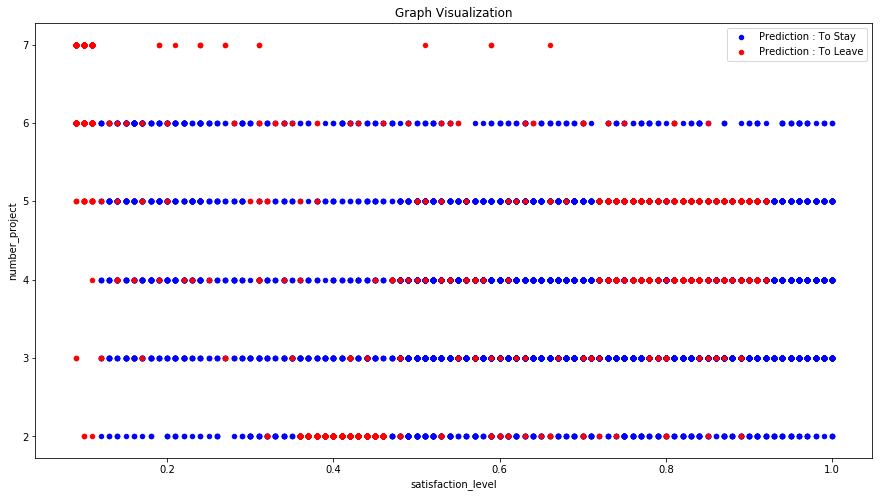

In [89]:
#First Graph : satifaction level vs number of project
df = format_data('train.csv',['left'])
plotGraphFeaturesPrimary(df,"satisfaction_level","number_project")

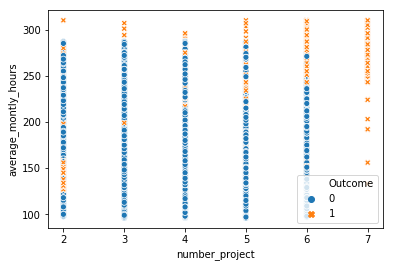

In [90]:
#Second Graph : number of projects vs average monthly hours
df = format_data('train.csv',['left'])
# df.head()
plotGraphFeaturesSecondary(df, "number_project" , "average_montly_hours")

# Part-5

## Graph : Training Error And Validation Error Vs Depth

Depth : 2
---Report---
The Accuracy :0.850166852057842
The Precision :0.8879309601664828
The Recall :0.42976356701311386
The F1 Score :0.5791939919782578
True Positive is:927.0001
False Negative is:1230.0001
True Negative is:6716.0001
False Positive is:117.0001
Depth : 3
---Report---
The Accuracy :0.9509454949944383
The Precision :0.8796459841021254
The Recall :0.9216504013305145
The F1 Score :0.9001584423673585
True Positive is:1988.0001
False Negative is:169.0001
True Negative is:6561.0001
False Positive is:272.0001
Depth : 4
---Report---
The Accuracy :0.9687430478309232
The Precision :0.9466666241269882
The Recall :0.9216504013305145
The F1 Score :0.933991032746908
True Positive is:1988.0001
False Negative is:169.0001
True Negative is:6721.0001
False Positive is:112.0001
Depth : 5
---Report---
The Accuracy :0.9750834260289211
The Precision :0.9707744305139376
The Recall :0.923968435422491
The F1 Score :0.9467933067179756
True Positive is:1993.0001
False Negative is:164.0001
True Neg

The Accuracy :0.978202846975089
The Precision :0.9518302690442123
The Recall :0.9536677785066493
The F1 Score :0.9527481378020684
True Positive is:494.0001
False Negative is:24.0001
True Negative is:1705.0001
False Positive is:25.0001
Depth : 15
---Report---
The Accuracy :0.9777580071174378
The Precision :0.9482756903158275
The Recall :0.9555982796917839
The F1 Score :0.9519229031065757
True Positive is:495.0001
False Negative is:23.0001
True Negative is:1703.0001
False Positive is:27.0001
Depth : 16
---Report---
The Accuracy :0.9759786476868327
The Precision :0.9393937729569042
The Recall :0.9575287808769186
The F1 Score :0.9483745895317058
True Positive is:496.0001
False Negative is:22.0001
True Negative is:1698.0001
False Positive is:32.0001
Depth : 17
---Report---
The Accuracy :0.9750889679715302
The Precision :0.9342103630788109
The Recall :0.9594592820620533
The F1 Score :0.9466664965080014
True Positive is:497.0001
False Negative is:21.0001
True Negative is:1695.0001
False Posit

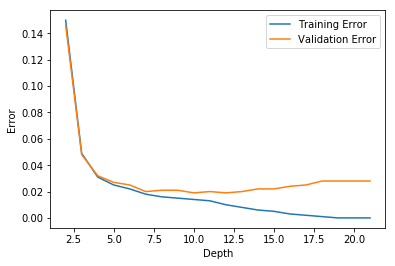

In [4]:
df=format_data('train.csv',['left'])
train_df,test_df= train_test_split(df,0.20)
max_depth = 22
trainingErrors = []
testErrors = []
indices = []
attributes = ["satisfaction_level","last_evaluation","number_project","average_montly_hours","time_spend_company","Work_accident","promotion_last_5years","sales","salary"]
for counter in range(0,2):
    for i in range(2, 22):
        print('Depth :' , i)
        print("---Report---")
        root = build_tree_entropy(train_df, attributes, 'Outcome',0,i)
        if counter == 0:
            accuracy = test_predictions(root, train_df)
            error = 1 - accuracy
            indices.append(i)
            trainingErrors.append(error)
        else:
            accuracy = test_predictions(root, test_df)
            error = 1 - accuracy
            testErrors.append(error)
# print(indices)
# print(trainingErrors)
# print(testErrors)
plotGraph(indices,trainingErrors,testErrors,"Depth")

## Graph : Training Error and Validation Error Vs Count of Nodes

2
The Accuracy :0.8176156583629893
The Precision :0.999999285715306
The Recall :0.2545455438016205
The F1 Score :0.40579715605961975
True Positive is:140.0001
False Negative is:410.0001
True Negative is:1698.0001
False Positive is:0.0001
3
The Accuracy :0.9399466192170819
The Precision :0.851099711979793
The Recall :0.9145453038017077
The F1 Score :0.8816826006371251
True Positive is:503.0001
False Negative is:47.0001
True Negative is:1610.0001
False Positive is:88.0001
4
The Accuracy :0.9559608540925267
The Precision :0.9077756210576416
The Recall :0.9127271226446827
The F1 Score :0.9102446381705754
True Positive is:502.0001
False Negative is:48.0001
True Negative is:1647.0001
False Positive is:51.0001
5
The Accuracy :0.9608540925266904
The Precision :0.9277776193416225
The Recall :0.9109089414876577
The F1 Score :0.9192659011868253
True Positive is:501.0001
False Negative is:49.0001
True Negative is:1659.0001
False Positive is:39.0001
6
The Accuracy :0.9626334519572953
The Precision 

The Accuracy :0.9776418242491658
The Precision :0.9412843631849207
The Recall :0.9656470149979279
The F1 Score :0.9533100624102148
True Positive is:2052.0001
False Negative is:73.0001
True Negative is:6737.0001
False Positive is:128.0001
18
The Accuracy :0.9779755283648498
The Precision :0.9421752691899706
The Recall :0.9661176031889314
The F1 Score :0.9539962403349219
True Positive is:2053.0001
False Negative is:72.0001
True Negative is:6739.0001
False Positive is:126.0001
19
The Accuracy :0.9779755283648498
The Precision :0.9421752691899706
The Recall :0.9661176031889314
The F1 Score :0.9539962403349219
True Positive is:2053.0001
False Negative is:72.0001
True Negative is:6739.0001
False Positive is:126.0001
20
The Accuracy :0.9779755283648498
The Precision :0.9421752691899706
The Recall :0.9661176031889314
The F1 Score :0.9539962403349219
True Positive is:2053.0001
False Negative is:72.0001
True Negative is:6739.0001
False Positive is:126.0001
21
The Accuracy :0.9779755283648498
The

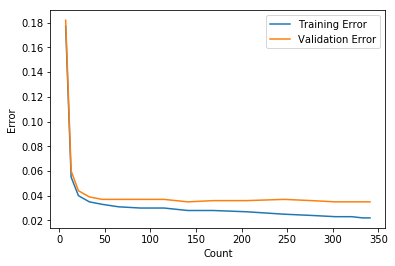

In [74]:
df=format_data('train.csv',['left'])
train_df,test_df= train_test_split(df,0.20)
max_depth = 20
errors = []
trainingErrors = []
testErrors = []
indices = []
attributes = ["satisfaction_level","last_evaluation","number_project","average_montly_hours","time_spend_company","Work_accident","promotion_last_5years","sales","salary"]
for counter in range(0,2):
    for i in range(2,22):
        print(i)
        global count
        count = 0
        if counter == 0:
            root = build_tree_entropy(train_df, attributes, 'Outcome',0,i)
            accuracy = test_predictions(root, test_df)
            error = 1 - accuracy
            indices.append(count)
            testErrors.append(error)
        else:
            root = build_tree_entropy(train_df, attributes, 'Outcome',0,i)
            accuracy = test_predictions(root, train_df)
            error = 1 - accuracy
            trainingErrors.append(error)
# print(indices)
# print(errors)
plotGraph(indices,trainingErrors,testErrors,"Count")

# Part-6

## Explaination as to how Decision Trees are suitable in handling missing values gracefully

### Decision Trees handle missing values in different approaches based on the kind of algorithm like C4.5 or ID3 or CART.
1. In C4.5 we take the probability distribution of the training data of the attribute for which we have to predict the label and then assign the prob. distribution  for the outcome label.
2. We can also prune the subtree to a single node based on the decision of the subtrees to give the least error
3. When at prediction time we encounter a node in the decision tree which tests a variable X, and for that variable we have in our instance a missing value than all the possibilities are explored. Thus, for each possible subnode a prediction is made. We keep the distribution for each sub node and we add them. Finally the class chosen for prediction is the class with the biggest density value. 
4. The Predicted value is the one with the maximum no. of instances in output(implemented in CART)
5. Use Mean Imputation Model : Take the median/average values and assign them to the missing values
6. Use Hot Deck Imputation Model : Randomly choose a sample which has similar values for other attributes except for the missing attribute